# Predictions of fraudlent users in a Bitcoin user network #

On platforms where users interact with each other to perform some type of financial transaction, it is very desirable to stop users who act in a fraudulent manner from being able to access or continue to use the platform. However, investigating users can be very expensive (consider e.g sellers on Ebay or Amazon) or impossible (consider users on a Bitcoin network) depending on the context. It is therefore worth asking the following - is it possible to perform accurate inference for the trustworthiness of users simply based on their behavior on the platform? We investigate this using publically available data for a Bitcoin user platform, where we observe ratings between users (and the times at which these ratings are made), and only know for a small subset of users whether they are trustworthy or not. 

## Summary of data ## 

For the dataset we are considering, we have 5,881 nodes (corresponding to separate users) and 35,592 weighted edges (corresponding to ratings from one user to another), along with time-stamp data; for example, a subset of the data looks like the following:

Source node | Target node | Rating | Time stamp
:----------:|:-----------:|:------:|:---------:
6 | 2 |	4 | 1289241912
6 | 5 | 2 | 1289241942
1 | 15 | 1 | 1289243140
4 | 3 | 7 | 1289245277
13 | 16 | 8 | 1289254254
13 | 10 | 8 | 1289254301
7 | 5 | 1 | 1289362700
2 | 21 | 5 | 1289370557

We note that ratings are integer valued between -10 to 10 (going from not-trustworthy to trustworthy) - when we analyse the data, we will normalize these to lie in [0, 1], and we will ignore the fact that user ratings are given on an integer scale. This is done mostly for computational reasons, as it will be more convenient to model ratings given by users on a continuous scale rather than a discrete one. The measurements for the time stamps are given as measurements of the time in seconds after 'Epoch' (January 1st 1970) in which the ratings were made; although we could try and use this information more substanatially (and e.g try and model trustworthiness as a function of time), for now we will only use it to compute per-node summary statistics. 

We also have some notion of "ground truth" data for the users in the network - there are 136 users which are considered trustworthy, and 180 not trustworthy users (so we have ground truth data for 316 users in total). Note that this is only for a subset of the users, so we will use a semi-supervised approach to modelling our data. As our end goal is to make inference for the trustworthiness for users, we will split the ground truth data in half (by randomly selecting indices) to form training and test sets.

Why split the ground truth data? Note that we only have partial information as to whether users are trustworthy, yet our overall goal is to infer some statistic of trustworthiness for **every** user. We therefore keep some of our ground truth data to the side so we can use it to ensure that our models are correctly calibrated when trying to make inference for the user trustworthiness. One last note: there is likely an imblance in the proportions of trustworthy/non-trustworthy users in the train/test sets, as compared to those in the whole population, and so this is something which we should be aware of when modelling our data.

## A quick caveat on our notion of ground truth ## 

Given that our data is taken from an inherently anonymous platform, you may (rightfully) ask whether the notion of 'ground-truth trustworthiness' comes from. For this dataset, the platform founder and those who they rated highly are considered to be trustworthy, and the users rated very lowly by the latter group are considered to be un-trustworthy. (In terms of the numerical specifics, I'm afraid I don't have those at hand - it's not very clear from the data source what exactly was done to obtain this information.) As a result, this is a clear limitation as to whether these users are actually acting fraudulently or not - instead we are really making inference for whether the platform holder would consider someone to be trustworthy. From e.g the perspective of the platform founder, this probably would suffice. 

## Evaluating model performance ## 

As our overall goal is to make inference for a latent state of each user (namely, whether they are trustworthy or not), the way in which we will evaluate our models will reflect this. In particular, we will examine ROC curves for labelled data in our training and test splits - note that as we can effectively treat an indicator of trustworthiness as a draw from a Bernoulli, we will usually be modelling a per-user probability of trustworthiness, which we can use then use in forming the AOC curves.

# Exploratory data analysis

Before beginning to model the data in order to try and make inference for the trustworthiness of different users, we begin by exploring some of the features of our dataset to see what could potentially be informative for the purposes of achieving our overall goal. In particular, we're going to examine the following statistics of the data:

* The in and out degree distribution (i.e, how many ratings a user has received and given respectfully)
* The distribution of the mean and average ratings recived and given by users 
* The standard deviation of the time at which ratings are made
* Rating asymmetry - the difference between the in and out degrees of a node, and simiarly the difference of the average in rating and out rating

For the users whose ground truth state is available, we'll highlight their distribution in blue and orange (corresponding to trustworthy and not-trustworthy respectfully), and otherwise keep the overall distribution in grey.

In [1]:
# Used to automatically reload imported scripts for debugging
%load_ext autoreload
%autoreload 1

In [2]:
%aimport eda

# If you want to verify the output, change display=False to display=True
eda.plot_summary_stat(display=False)

c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


![title](img/summary_stat.png)

Examining the above plots, we see that in terms of node-level information we can use to try and predict whether a user is trustworthy, we observe that there are a few discriminating features we could try and use:

* **The average rating received** - Somewhat unsuprisingly, the average rating received by untrustworthy users is lower than that of trustworthy users, and lies on the left tail of the overall distribution of average ratings. 
* **The standard deviation of ratings given and received** - As observable from the two graphs, large observed values of the standard deviation of the ratings given or received by a user are more likely to come from users who have been deemed non-trustworthy, compared to both the base population and users who are considered trustworthy. For the ratings received, this is not too unsuprising - one can imagine that a collection of conspiring users who are not trustworthy will try and collectively give each other large positive ratings, while other users will give them large negative ratings. However, it is a bit more difficult to try and think of a reason as to why the standard deviation of the ratings given seems to vary across the different population.
* **Standard deviation of rating times** - This appears to be a somewhat weaker form of evidence, but we note that a large proportion of un-trustworthy users are only active for a short period of time, whereas the distribution of trustworthy is more uniform (and similarly so for the overall population of users).

Given this, we'll therefore begin by looking at the level of performance given by a simple Bayesian logistic regression model using the above variables as covariates, and see what level of performance this gives us in terms of false positives/negatives.

# Model 1: A straightforward Bayesian logistic regression

We'll begin by fitting the following Bayesian logistic regression model based off the examination above: we'll suppose that user $i$ has a trustworthy indicator $a_i$ with $a_i = 1$ corresponding to a user being trustworthy and $a_i = 0$ not trustworthy. We'll then suppose that the $a_i$ are independent Bernoulli random variables, whose probability of success $p_i$ conditional on 

* The average rating received $\mathrm{R}_i$, centered to lie within $[-0.5, 0.5]$ (see footnote [a] for more info);
* The standard deviation of ratings given $\mathrm{SDG}_i$ and received $\mathrm{SDR}_i$, rescaled to lie within $[0, 1]$ (see footnote [b] for more info); and
* The standard deviation of rating times $\mathrm{SDT}_i$ given, rescaled to lie within $[0, 1]$ (see footnote [c] for more info),

is given by 

$$ \log\Big( \frac{p_i}{1 - p_i} \Big) = \mu + \beta_R \cdot \mathrm{R}_i + \beta_{SDG} \cdot \mathrm{SDG}_i + \beta_{SDR} \cdot \mathrm{SDR}_i + \beta_{SDT} \cdot \mathrm{SDT}_i. $$

Note that we want our model to accurately express "in-difference" for new users - if we have no information about a user, we should want the probability of a user being trustworthy to be (at least approximately) equal to the proportion of trustworthy users in the population. Given that the data for which we have labels inherently correspond to users which we have a sufficient amount of information about, the easiest way of forcing this constraint is to ensure that i) for users for which we have no information about, all of the relevant covariates are equal to zero, and ii) we include an intercept term, which will hopefully capture the proportion of trustworthy users in the network. For users with no ratings, all of the relevant standard deviations can be set to zero, and similarly we can force the average rating received to be equal to zero for users with no ratings. We have also normalized the various variables so that they are on the same scale, as otherwise we will encounter difficulties when it comes to computation.

In fitting the above model, we place independent $\mathrm{Normal}(0, 1)$ priors on each of the non-intercept regression parameters (note that as we have normalized our covariates to be on the same scale, we also keep our prior variables on the same scale too), and a $\mathrm{Normal}(0, 10)$ prior on the intercept parameter. As we can only fit the above model on the data points for which we have the ground truth labels and lie within our training set, we fit the described model using MCMC. 

------------

[a] Given ratings in $[0, 1]$, we simply shift the values to lie in [-0.5, 0.5] via the mapping $x \mapsto x - 0.5$.

[b] It is is a relatively well known fact that for any random variable which takes values in $[0, 1]$, it's variance must lie in the interval $[0, 0.25]$, and hence the standard deviation must lie within $[0, 0.5]$. We therefore multiply the observed standard deviation by two in order to obtain values in $[0, 1]$. We also note that some of the standard deviations given are NaNs, in which case we set them equal to be equal to zero.

[c] We handle the standard deviation of rating times in a slightly more complicated fashion than previously, as the empirical distribution of the rating times has a power law type distribution, meaning that simply diving by the observed maximum value will force most of the observed values to be very close to zero. While usually one would try and take logarithms to handle such data, we cannot do so naively as we have a large number of zeros (corresponding to users with either zero or one rating only). We therefore use a slight hack, and transform the variables according to $x \mapsto \log(x+1)$, and then divide by the observed maximum value after performing this transformation.

In [3]:
%aimport bayes
%aimport bitcoin
%aimport roc
import torch
import numpy as np

# Comment out the appriopate line depending on testing/running full model
# hmc_arg_dict = {'model_num': 1, 'num_samples': 50, 'warmup_steps': 10}
hmc_arg_dict = {'model_num': 1, 'num_samples': 1000, 'warmup_steps': 1000}

# Run MCMC to get draws from the posterior distribution for the regression coefs
hmc_samples = bayes.bayes_logistic_reg(**hmc_arg_dict)

c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
sample: 100%|█████████████████████████████████| 2000/2000 [04:05<00:00,  8.14it/s, step size=3.37e-01, acc. prob=0.924]


Site: mu
       mean       std        5%       25%       50%      75%       95%
0 -0.659628  0.442722 -1.386281 -0.975313 -0.667065 -0.34239  0.055191 

Site: beta_r
       mean       std        5%       25%       50%       75%       95%
0  4.524391  0.704051  3.400012  4.021974  4.532902  5.028489  5.679123 

Site: beta_sdg
       mean       std       5%       25%       50%       75%       95%
0  0.416836  0.738809 -0.77765 -0.093458  0.388938  0.918144  1.656759 

Site: beta_sdr
       mean       std        5%       25%       50%       75%       95%
0 -2.029045  0.736118 -3.225803 -2.535095 -2.061826 -1.529543 -0.804033 

Site: beta_sdt
      mean       std        5%       25%       50%       75%       95%
0  2.66987  0.593216  1.695595  2.279418  2.699809  3.066647  3.603673 



## Criticism for Model 1 ##

We'll begin by looking at the ROC curves produced by looking at the classifier created by the above model.

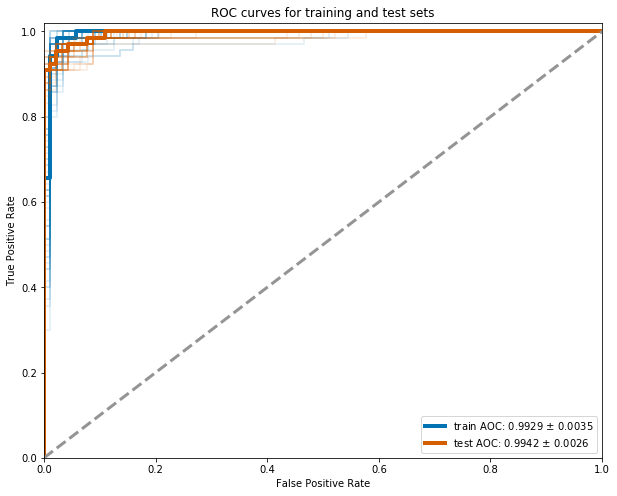

In [4]:
# Import data, transform covariates to make test set predictions/do posterior predictive checks
data = bitcoin.BitcoinOTC()

r = data.in_weight_avg - 0.5
sdg = 2*data.out_weight_std
sdr = 2*data.in_weight_std
sdt = torch.log(data.rate_time_out_std + 1)
sdt = sdt/sdt.max()
gt = data.gt

# Set all NaN values to zero
sdg[sdg != sdg] = 0
sdr[sdr != sdr] = 0
sdt[sdt != sdt] = 0

# Create 5*(num of samples) matrix of regression coefficients from hmc_samples
reg_coefs = []
for value in hmc_samples.values():
    reg_coefs.append(value)
    
reg_coefs = np.array(reg_coefs)

# Create (num of train/test points)*4 matrix of covariates 
tt_str_list = ['train', 'test']
logits = dict.fromkeys(tt_str_list)

for i, split in enumerate([data.nodes_train, data.nodes_test]):
    # Create (number of data points)*5 matrix of covariates of numpy type
    covs = np.array([np.ones(len(split)), r[split].numpy(), sdg[split].numpy(), 
                     sdr[split].numpy(), sdt[split].numpy()])
    
    # Multiply together to give (num of data points)*(num of samples) array
    logits[tt_str_list[i]] = covs.transpose() @ reg_coefs
    
# Create dict of ground truth labels for test and training set
gt_labels = {'train': gt[data.nodes_train].numpy(), 'test': gt[data.nodes_test].numpy()}
           
# Create/plot ROC curve for training and test set 
roc.plot_roc_curve(gt=gt_labels, logits=logits, fname='img/bayes_1_roc.png', display=False)

![title](img/bayes_1_roc.png)

Here, we use each draw from the posterior distribution to form logit scores for the probability of trustworthiness, calculate the ROC and the corresponding AOC, and then average over our draws from the posterior distribution. Looking at this curve, you may think that we effectively have a perfect classifier, and so our task is done. However, what we are really interested in is obtaining correctly calibrated probabilities of trustworthiness; that is, if we had e.g $100$ users who had estimated trustworthiness probability equal to (say) $0.8$, then approximately $80$ should be trustworthy. If we plot a calibration curve based off the test set data, we see that this isn't the case:

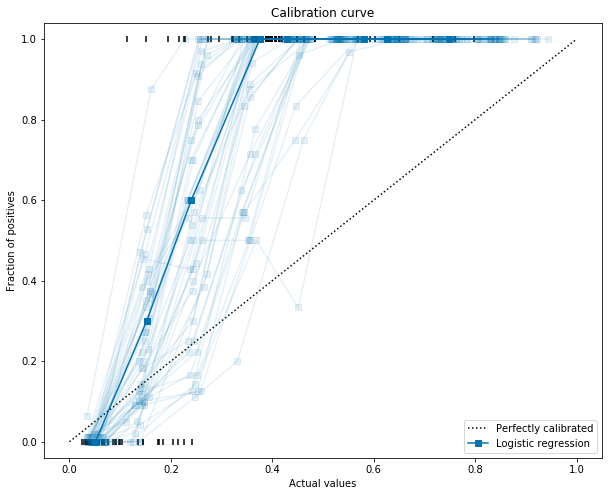

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve

def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i in range(logits['test'].shape[1]):
    if i % 20 == 0:
        frac_positive, mean_pred = calibration_curve(gt_labels['test'],
                                                     sigmoid(logits['test'][:, i]),
                                                     n_bins=10)
        plt.plot(mean_pred, frac_positive, 's-', color='#0173B2', alpha=0.1)

frac_positive, mean_pred = calibration_curve(gt_labels['test'], 
                                             sigmoid(np.mean(logits['test'], axis=1)),
                                             n_bins=10)
plt.plot(mean_pred, frac_positive, 's-', color='#0173B2',
         label='Logistic regression')

plt.scatter(sigmoid(np.mean(logits['test'], axis=1)), gt_labels['test'], 
         color='k', marker='|')
         
plt.xlabel('Actual values')
plt.ylabel('Fraction of positives')
plt.ylim([-0.04, 1.04])
plt.legend(loc="lower right")
plt.title('Calibration curve')

plt.savefig('img/bayes_1_calib_curve.png', bbox_inches='tight')

![title](img/bayes_1_calib_curve.png)

For our probabilities to be correctly calibrated, they should lie close to the diagonal line - we can see that this is clearly not the case here.

To see some other aspects for which the above approach leaves something to be desired, we plot the distribution of estimated trustworthiness probabilities across the population of users in the network:  

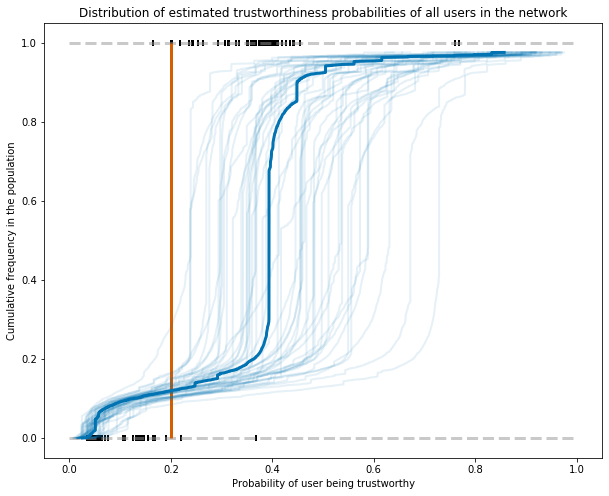

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

covs = np.array([np.ones(len(r.numpy())), r.numpy(), sdg.numpy(), sdr.numpy(), sdt.numpy()])
logits_pop = covs.transpose() @ reg_coefs
logits_pmean = np.mean(logits_pop, axis=1)

plt.figure(figsize=(10, 8))

for i in range(logits_pop.shape[1]):
    if i % 20 == 0:
        plt.plot(sigmoid(np.sort(logits_pop[:, i])), np.linspace(0, 1, len(logits_pop[:, i]), 
                 endpoint=False), color='#0173B2', lw=2, alpha = 0.1)
        
plt.plot(sigmoid(np.sort(logits_pmean)), np.linspace(0, 1, len(logits_pmean), endpoint=False),
         color='#0173B2', lw=3)

plt.hlines(0, 0, 1, color='#949494', lw=3, linestyle='--', alpha=0.5)
plt.hlines(1, 0, 1, color='#949494', lw=3, linestyle='--', alpha=0.5)
plt.vlines(0.2, 0, 1, color='#D55E00', lw=3, linestyle='-')

plt.scatter(sigmoid(logits_pmean[data.nodes_train]), gt[data.nodes_train].numpy(), 
            color='k', marker='|', lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Probability of user being trustworthy')
plt.ylabel('Cumulative frequency in the population')
plt.title('Distribution of estimated trustworthiness probabilities of all users in the network')
plt.savefig('img/bayes_1_logit_pop.png', bbox_inches='tight')

![title](img/bayes_1_logit_pop.png)

Here the bold blue line corresponds to the empirical c.d.f produced using the posterior mean of the estimated logits. Tick marks are also displayed corresponding to the estimated probabilities for the users which lie in the training set, plotted at $y = 0$ if they are not trustworthy, and $y = 1$ if they are trustworthy; the orange line corresponds to the threshold probability used for prediction. In addition to the threshold probability being low (a more natural threshold would usually be $0.5$), we see that there is a vertical jump in the c.d.f at around $p= 0.4$. This corresponds to the users for which we have little information, and so we would expect this jump to occur at the proportion of trustworthy users in the total population. However, according to the threshold we have, we would expect approximately $10\%$ of users to be not trustworthy, meaning we have a disparity between the two. 

To fix this calibration issue, we want to try and form a generative model which holistically reflects the latent structure of the underlying network. 

# Model 3: A first attempt at a structural model for network data



# Stochastic Black Box Variational Inference for Network Data

Recall that in variational inference, the goal is to approximate a desired posterior distribution $p(\mathbf{z} | \mathbf{x})$ of some latent variables $\mathbf{z}$ given our data $\mathbf{x}$ using a variational family $q(\mathbf{z} | \lambda)$, with $\lambda$ parameterizing our variational family. To try and do so in an automated fashion, we update $\lambda$ via performing gradient ascent on the ELBO, whose gradient is 

$$ \nabla_{\lambda} \mathrm{ELBO} = \mathbb{E}_{\mathbf{z} \sim q(\cdot|\lambda) }\Big[ \nabla_{\lambda} \log q(\mathbf{z} | \lambda) \big\{ \log p(\mathbf{x}, \mathbf{z}) - \log q(\mathbf{z} | \lambda) \big\} \Big]   $$

In practice, we then usually make use of the two following ideas in order to perform computationally efficient inference:

* **Approximating the expectation** - We draw samples from $\mathbf{z} \sim q(\cdot | \lambda)$ to give a Monte Carlo estimate of the above expectation;
* **Approximating the log-likelihood** - To illustrate through an example, suppose we are in a regime where the likelihood for the data factors as $p(\mathbf{x} | \mathbf{z}) = \prod_{i=1}^N p(x_i | z_i)$ - i.e we have $N$ data points $x_i$ which are conditionally independent given local latent variables $z_i$. If our number of data points $N$ is large, rather than compute $\sum_{i=1}^N \log p(x_i | z_i) + \log(z_i)$, we instead draw a subset $I_M$ of $M$ data points and instead use the approximation
$$ \sum_{i=1}^N \big\{ \log p(x_i | z_i) + \log(z_i) \big\} \approx \frac{N}{M} \sum_{i \in I_M} \big\{ \log p(x_i | z_i) + \log(z_i) \big\}. $$
This works well in practice even when $M \ll N$, i.e when the number of subsampled data points is far smaller than the total number. 

Focusing on the latter idea for now, this approach of subsampling data points is very intuitive for when we are fitting data which either naturally arises as being conditionally independent (such as for data we may consider modelling through a traditional regression), or we can extract some statistics from our data which can then be modelled in the same way (consider for example a topic model given a set of documents, where all we use are counts of words from a group of documents). 

However, for certain types of structured data, some care and thought is required in trying to exploit ideas of subsampling to approximate the log-likelihood. Suppose we observe a undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ where the number of nodes $|\mathcal{V}| = N$, and $\mathcal{E}$ is the list of edges; we can also equivalently think of having observed an adjacency matrix $A = (a_{ij})_{i, j \in \mathcal{V}}$. Some real-world examples of data collected in this format include:

* **Social networks** - Here, users of the social network correspond to the vertices, and edges correspond to whether they are e.g friends on the network. You can imagine that we also have nodal information corresponding to characteristics of each user; for example, age, gender, geographical location, hobbies/interests and et cetera.
* **Protein-protein interaction networks** - In these networks, we look at different proteins within a particular type of cell, and form a network with proteins as vertices, and edges denoting whether two proteins contribute to a shared biological function.
* **User-trust networks** - Here, users correspond to vertices, with an edge from one vertex to the other corresponding to a user providing a rating, the edge label corresponding to a rating of trust one user gave to another.

In the first two examples, we note that the presence of the edge between two vertices should be more likely if the two vertices have comparable latent features, and in the latter the distribution of the edge labels (that is, the ratings between users) should be different if a non-fraudlant user is rating a fruadlant user, as compared to a fraudlant user rating rating another fraudlant user. To summarize, for network data, while we care about making latent observations about each observed vertex, we need to do so using some amount of edge information. 

For such a network (supposing for now it is directed and without self-loops), we could imagine trying to form a Bayesian model of the form  

$$ \begin{aligned}
p(\omega_1, \ldots, \omega_N) &= \prod_{i=1}^N N(\omega_i \,|\, 0, \eta^2 I_d) \\
p(\{ a_{ij} \,|\, i \neq j \} \,|\, \omega_1, \ldots, \omega_n) &= \prod_{i \neq j} \mathrm{Bernoulli}\big(a_{ij} \,\big|\, \sigma(\langle \omega_i, \omega_j \rangle) \big)
\end{aligned}$$

where $\eta^2$ is specified in advance, and $\sigma(x) = e^x/(1+e^x)$ is the logistic function. We can then write the log-likelihood down as 

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) = \sum_{i \neq j} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \sum_{i=1}^n \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

If we now let $S(\mathcal{G}) = (\mathcal{V}', \mathcal{E}')$ denoted a "subsampled" version of the network, where $\mathcal{V}' \subseteq \mathcal{V}$ and $\mathcal{E}'$ is a list of pairs of vertices $\mathcal{E}'$ (note that this may necessarily not be a subset of $\mathcal{E}$ of our original edge set), we could approximate the log-likelihood by 

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) \approx \frac{ N(N-1)  }{ |\mathcal{E}'| } \sum_{(i, j) \in \mathcal{E}'} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \frac{ N }{ |\mathcal{V}'|   } \sum_{i \in \mathcal{V}'} \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

We now need to address the question of how we choose $S(\mathcal{G})$. Although there are some obvious first examples (e.g sample edges randomly), the work of Grover and Leskovec introduced "node2vec" [1], which uses biased random walks to help form $S(\mathcal{G})$. Later work by Vietch et al. [2] highlights that the **choice of sampling scheme is a modelling decision**, with some on-going work (D. and Austern, [3]) making explicit how changing the sampling scheme effects the latent structure recovered (under the assumption that the graph is exchangable). The important take-away from this is as follows:

> **For the purposes of Box's loop, we should take into account our choice of sampling scheme as part of our modeling step, moreso than as part of our inference step.**

One final remark: so far we've been talking implicitly about using variational inference to approximate the posterior distribution. Beyond the inability to use subsampling methods for MCMC methods to obtain samples from the posterior, there is one other thing to note: given the form of the likelihood and prior on the $\omega_i$ and $a_{ij}$ as above, the posterior will be _rotationally invariant_; that is, if $Q \in \mathbb{R}^{d \times d}$ is an orthogonal matrix, then 

$$ Q\omega_1, \ldots, Q \omega_N | a_{ij}, i \neq j \stackrel{\text{d}}{=} \omega_1, \ldots, \omega_N | a_{ij}, i \neq j. $$

As a consequence, the posterior mean (for example) of the $\omega_i$ will be equal to zero, and so extracting sensible summary statistics from our learned embeddings will be far more difficult. (For those familar with MCMC methods, this can be thought of as being due to a lack of identifiability of the $\omega_i$ in the above model, and so infact we would expect to have other computational difficulties in trying to sample from the posterior.) 

# References

[1] - 

[2] - 

[3] - 